import section

In [1]:
import sensor_msgs.point_cloud2 as pc2
from sensor_msgs.msg import PointCloud2, LaserScan
from visualization_msgs.msg import Marker
import laser_geometry.laser_geometry as lg
import rosbag
import ros_numpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import rospy
import pandas as pd
import pickle
import math
#import rospy
#from visualization_msgs.msg import Marker
from geometry_msgs.msg import Quaternion, Pose, Point, Vector3
from std_msgs.msg import Header, ColorRGBA
from doors_and_corners.msg import Wall, WallList, Door, DoorList, Corner, CornerList, Corridor, CorridorList
import itertools
from copy import deepcopy
from scipy import stats
import os

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


class copy pasted from code. changed init to accept data and to not use the subscriber but directly send data into callback

In [2]:
class LineExtractionPaper():
    """
    exploring what is being said and done in
        "Line Extraction in 2D Range Images for Mobile Robotics"
    """


    def __init__(self, data):

        # defining constants
        self.ANGLE_INCREMENT = 0 # 0.017501922324299812 # radians
        self.ANGLES = []

        self.SIGMA_R = 0.03 # meters
        self.LAMBDA = 0.174533 # radians = 10 degrees
        self.D_MAX_CONSTANT = math.sin(self.ANGLE_INCREMENT)/math.sin(self.LAMBDA-self.ANGLE_INCREMENT)


        self.Z_OFFSET = 0.1

        # marker constants
        self.base_marker_type = Marker.LINE_STRIP
        self.base_marker_lifetime = rospy.Duration(0.3)
        # self.base_marker_lifetime = rospy.Duration(10)
        self.base_marker_header_frame_id = 'cloud'
        self.base_marker_action = 0
        self.base_marker_scale_x = 0.01
        self.base_marker_pose_orientation = Quaternion(0.0, 0.0, 0.0, 1.0)

        self.marker_id = 0
        self.point_id = 0

        # feature collection
        self.list_of_walls = WallList()
        self.list_of_doors = DoorList()
        self.list_of_corners = CornerList()
        self.list_of_corridors = CorridorList()


        self.callback(data)

    def polar_to_cartesian(self, distance, angle):
        """ This function converts polar coordinates to cartesian coordinates

        The sin of the angle is the Y coordinate, the cosin of the angle is the X coordinate

        Args:
            distance (float): The distance that the Robot is away from the point that is being viewed
            angle    (float): The angle (in radians) that the Robot is away from the point that is being viewed

        Returns:
            pointX (float): the X coordinate
            pointY (float): the Y coordinate

        """
        pointX = distance * math.cos(angle)
        pointY = distance * math.sin(angle)
        return pointX, pointY

    def distance(self, a, b):
        """ This is a distance function that returns the distance between the 2 given points

        Args:
            a (Point): a point with x and y coordinates
            b (Point): a point with x and y coordinates

        Returns:
            dist (float): the distance between the 2 given points
        """
        dist = (b.x - a.x) ** 2 + (b.y - a.y) ** 2
        return math.sqrt(dist)

    def distance_line_to_point(self, p1, p2, p3):
        """ This function finds the shortest distance between a line defined by two points and another point
        The distance of the line calculated will always be perpendicular to the line the first two points span

        Args:
            p1 (Point): one point of the line. The distance to this line is what we want to calculate
            p2 (Point): the other point of the line. The distance to this line is what we want to calculate
            p3 (Point): this is the point whose distance to the line we are interested in

        Returns:
            dist (float): the distance from the point to the line
        """
        numerator = abs((p2.y - p1.y) * p3.x - (p2.x - p1.x) * p3.y + p2.x * p1.y - p2.y * p1.x)
        denominator = self.distance(p1, p2)
        dist = numerator / denominator
        return dist

    def angle_between_points(self, point1, point2):
        """
        Calculates the angle of a line relative to the robot at (0,0) where the
        line is defined by 2 points.


        Args:
            point1 (Point): first point
            point2 (Point): second point

        Returns:
            deg (float): Angle in degrees between the two points
        """
        x1 = point1.x
        y1 = point1.y
        x2 = point2.x
        y2 = point2.y
        dX = x2 - x1
        dY = y2 - y1
        rads = math.atan2(dY, dX)
        deg = math.degrees(rads)
        return deg

    def angle_between_lines(self, line1, line2):
        """
        Calculates the angle between 2 lines by first determining the angle of the individual
        lines and then subtracting them from each other

        Args:
            line1 (List): List of start and end Point of the line with respective flags
            line2 (List): List of start and end Point of the line with respective flags

        Returns:
            angle_of_lines (float): angle between the two lines in degrees
        """
        angle_line1 = self.angle_between_points(line1.wall_start, line1.wall_end)
        angle_line2 = self.angle_between_points(line2.wall_start, line2.wall_end)
        angle_of_lines = (angle_line1 - angle_line2) % 360
        return angle_of_lines

    def create_wall(self, start_point, end_point):
        """
        This function exsists solely to create a uniform wall object. It is important to note,
        going from the start_point to the end_point, if one looks to the left side of that, there
        is to be empty, traversable space.

        Args:
            start_point (List): the start point of the wall with the flaggs associated with that point
            end_point (List): the end point of the wall with the flaggs associated with that point

        Returns:
            wall (List): list containing the first and last point of a wall, indicating the
                         straight line segment created by the wall
        """
        new_wall = Wall()
        new_wall.wall_start = start_point[0]
        new_wall.wall_end = end_point[0]
        new_wall.wall_start_rupture = start_point[2]
        new_wall.wall_start_break = start_point[3]
        new_wall.wall_end_rupture = end_point[2]
        new_wall.wall_end_break = end_point[3]
        return new_wall

    def create_door(self, door_list, first_wall, second_wall):
        """
        This function exsists solely to create a uniform wall object. It is important to note,
        going from the start_point to the end_point, if one looks to the left side of that, there
        is to be empty, traversable space.

        Args:
            start_point (List): the start point of the wall with the flaggs associated with that point
            end_point (List): the end point of the wall with the flaggs associated with that point

        Returns:
            wall (List): list containing the first and last point of a wall, indicating the
                         straight line segment created by the wall
        """
        new_door = Door()
        #[wall1.wall_end, 0, wall1.wall_end_rupture, wall1.wall_end_break], [wall2.wall_start, 0, wall2.wall_start_rupture, wall2.wall_start_break])
        new_door.door_start = first_wall.wall_end
        new_door.door_end = second_wall.wall_start
        new_door.door_start_rupture = first_wall.wall_end_rupture
        new_door.door_start_break = first_wall.wall_end_break
        new_door.door_end_rupture = second_wall.wall_start_rupture
        new_door.door_end_break = second_wall.wall_start_break
        door_list.door_list.append(new_door)

    def create_corner(self, corner_list, first_wall, second_wall):
        """
        This function exists to create a uniform corner type. The input is:
        - a list where the corner is to be appended to
        - the 2 touching walls forming the corner
        The two walls are placed into a list. By "walking" from the first wall to the second wall
        we can safely assume that to the left of each wall there is a free space where the robot
        could traverse.
        With these two walls we determine if the corner is pointing to the robot (inner corner) or
        away from the robot (outer corner) by creating a triangle with both walls and determining
        the relative position of the robot to this triangle

        Args:
            corner_list (List): the list that will contain all existing corners
            first_wall (List): the list of the points describing the first wall. Each point is made up of a
                               list with the Point corrdinates and the flaggs associated
            second_wall (List): the list of the points describing the second wall. Each point is made up of a
                                list with the Point corrdinates and the flaggs associated
        """

        wall_one_start = first_wall.wall_start
        corner = first_wall.wall_end
        wall_two_end = second_wall.wall_end

        # We want to determine if the corner is an inner or an outer wall.
        # We do this by taking the two walls that form a corner and combine them
        # into a triangle.
        # If we are dealing with an Inner corner the distance from the Robot to the
        # corner will be less than the distance to the tangent line and the distance
        # to the tangent line will be greater coming from the robot, than from the corner
        # In all other cases we are dealing with an outer wall

        # inner = False
        corner_type = 0

        distance_to_corner = self.distance(corner, Point(0,0,self.Z_OFFSET))
        distance_to_imaginary_wall = self.distance_line_to_point(wall_one_start, wall_two_end, Point(0,0,self.Z_OFFSET))
        corner_to_imaginary_wall = self.distance_line_to_point(wall_one_start, wall_two_end, corner)

        if distance_to_corner < distance_to_imaginary_wall and not distance_to_imaginary_wall < corner_to_imaginary_wall:
            # inner = True
            corner_type = 1

        new_corner = Corner()
        new_corner.first_wall = first_wall
        new_corner.second_wall = second_wall
        new_corner.corner_type = corner_type

        corner_list.corner_list.append(new_corner)

    def create_potential_corner(self, corner_list, wall):
        """
        This function creates a uniform type of corner. It is similar to create_corner. The difference
        is we are dealing with only a single wall and thus have to guess if the wall segment that has a
        breakpoint or a rupturepoint in the current scan, is a corner.

        Args:
            corner_list (List): the list that will contain all existing corners

            wall (List):        the list of the points describing the first wall. Each point is made up of a
                                list with the Point corrdinates and the flaggs associated
        """

        add_potential_corner = True
        minimum_distance_to_a_corner = 0.2 # 10 centimeters may be a bit small
        for existing_corner in [x.first_wall.wall_end for x in corner_list.corner_list]:
            first_distance = self.distance(existing_corner, wall.wall_start)
            second_distance = self.distance(existing_corner, wall.wall_end)
            if first_distance < minimum_distance_to_a_corner or second_distance < minimum_distance_to_a_corner:
                add_potential_corner = False
                break

        if add_potential_corner:
            temp_wall = self.create_wall([wall.wall_end, 0, False, False], [wall.wall_end, 0, False, False])
            if wall.wall_end_rupture or wall.wall_end_break:
                new_corner = Corner()
                new_corner.first_wall = wall
                new_corner.second_wall = temp_wall
                new_corner.corner_type = 2
                corner_list.corner_list.append(new_corner)

            if wall.wall_start_rupture or wall.wall_start_break:
                new_corner = Corner()
                new_corner.first_wall = temp_wall
                new_corner.second_wall = wall
                new_corner.corner_type = 2
                corner_list.corner_list.append(new_corner)



    def minimum_distance_between_lines(self, wall1, wall2):
        """ distance between two lines
        Args:
            wall1 (Wall): first Wall
            wall2 (Wall): second Wall
        Returns:
            distance (float): minimum Euclidean distance between two Lines
        """
        if self.line_intersection(wall1, wall2)[0]: return 0
        # try each of the 4 vertices w/the other segment
        distances = []
        distances.append(self.distance_line_to_point(wall1.wall_start, wall1.wall_end, wall2.wall_start))
        distances.append(self.distance_line_to_point(wall1.wall_start, wall1.wall_end, wall2.wall_end))
        distances.append(self.distance_line_to_point(wall2.wall_start, wall2.wall_end, wall1.wall_start))
        distances.append(self.distance_line_to_point(wall2.wall_start, wall2.wall_end, wall1.wall_end))
        return min(distances)

    # def line_intersection(self, wall1, wall2):
    #     xdiff = (wall1.wall_start.x - wall1.wall_end.x, wall2.wall_start.x - wall2.wall_end.x)
    #     ydiff = (wall1.wall_start.y - wall1.wall_end.y, wall2.wall_start.y - wall2.wall_end.y)
    #
    #     def det(a, b):
    #         return a[0] * b[1] - a[1] * b[0]
    #
    #     div = det(xdiff, ydiff)
    #     if div == 0:
    #        return None, None # returning None as these walls do not intersect
    #
    #     d = (det([wall1.wall_start.x, wall1.wall_start.y],[wall1.wall_end.x, wall1.wall_end.y]), det([wall2.wall_start.x, wall2.wall_start.y],[wall2.wall_end.x, wall2.wall_end.y]))
    #     x = det(d, xdiff) / div
    #     y = det(d, ydiff) / div
    #     return x, y

    def line_intersection(self, wall1, wall2): #Ax1, Ay1, Ax2, Ay2, Bx1, By1, Bx2, By2):
        """ returns a (x, y) tuple or None if there is no intersection """
        wall1_start_x = wall1.wall_start.x
        wall1_start_y = wall1.wall_start.y
        wall1_end_x =   wall1.wall_end.x
        wall1_end_y =   wall1.wall_end.y
        wall2_start_x = wall2.wall_start.x
        wall2_start_y = wall2.wall_start.y
        wall2_end_x =   wall2.wall_end.x
        wall2_end_y =   wall2.wall_end.y
        d = (wall2_end_y - wall2_start_y) * (wall1_end_x - wall1_start_x) - (wall2_end_x - wall2_start_x) * (wall1_end_y - wall1_start_y)
        if d:
            uA = ((wall2_end_x - wall2_start_x) * (wall1_start_y - wall2_start_y) - (wall2_end_y - wall2_start_y) * (wall1_start_x - wall2_start_x)) / d
            uB = ((wall1_end_x - wall1_start_x) * (wall1_start_y - wall2_start_y) - (wall1_end_y - wall1_start_y) * (wall1_start_x - wall2_start_x)) / d
        else:
            return None, None
        if not(0 <= uA <= 1 and 0 <= uB <= 1):
            return None, None
        x = wall1_start_x + uA * (wall1_end_x - wall1_start_x)
        y = wall1_start_y + uA * (wall1_end_y - wall1_start_y)

        return x, y


    def show_point_in_rviz(self, point, point_color=ColorRGBA(0.0, 1.0, 0.0, 0.8)):
        """ This function takes a point to then place a Marker at that position
        With an optional argument to set the color

        Args:
            point        (Point): Point to be displayed
            (point_color (ColorRGBA)): Optional color argument to change the color of the point
        """
        marker = Marker(
                    header=Header(
                    frame_id=self.base_marker_header_frame_id),
                    id=self.point_id,
                    type=Marker.SPHERE,
                    pose=Pose(point, Quaternion(0, 0, 0, 1)),
                    scale=Vector3(0.1, 0.1, 0.1),
                    color=point_color,
                    lifetime=self.base_marker_lifetime)
        self.point_id += 1

    def show_line_in_rviz(self, start_point, end_point, line_color=ColorRGBA(1, 0, 0, 0.7)):
        """ This function takes two points to then place a Marker line in the frame
        With an optional argument to set the color

        Args:
            start_point       (Point): Start Point from the line to be displayed
            end_point         (Point): End Point from the line to be displayed
            (point_color      (ColorRGBA)): Optional color argument to change the color of the point
        """
        marker = Marker()
        marker.type = self.base_marker_type
        marker.id = self.marker_id
        marker.lifetime = self.base_marker_lifetime
        marker.header.frame_id = self.base_marker_header_frame_id
        marker.action = self.base_marker_action
        marker.scale.x = self.base_marker_scale_x
        marker.pose.orientation = self.base_marker_pose_orientation

        marker.points.append(start_point)
        marker.points.append(end_point)
        marker.colors.append(line_color)
        marker.colors.append(ColorRGBA(0, 0, 1, 0.7))

        

        self.marker_id += 1

    def print_wall(self, wall):
        """
        Function to show the lines of a wall or door
        TODO make it see "missing doors" as open doors

        Args:
            wall (List): list of points defining the boundry of the wall
        """
        line_color = ColorRGBA(1, 0, 0, 0.7)
        self.show_line_in_rviz(wall.wall_start, wall.wall_end, line_color)

    def print_door(self, door):
        line_color = ColorRGBA(0, 1, 0, 0.7)
        self.show_line_in_rviz(door.door_start, door.door_end, line_color)

    def print_corner(self, corner):
        """
        Function to show the current corner

        Args:
            corner (List): list containing two walls, representing the walls that touch
                           and form a corner and an int indicating the corner type.
                           0 means the corner is an outer corner. 1 means the corner is an
                           inner corner. 2 means the corner is only a potential corner
        """
        corner_color = ColorRGBA(1, 0, 0, 0.7)
        if corner.corner_type == 1:
            corner_color = ColorRGBA(0, 1, 0, 0.7)
        elif corner.corner_type == 2:
            corner_color = ColorRGBA(1, 0, 1, 0.7)

        self.show_point_in_rviz(corner.first_wall.wall_end, corner_color)

    def print_corridor(self,corridor):
        self.show_point_in_rviz(corridor, ColorRGBA(1.0, 1.0, 0.0, 0.8))

    def callback(self, data):
        """ Essentially the main function of the program, this will call any functions
        required to get to the final answer: what set of points is a door
        Args:
            data (LaserScan): the data that the LaserScan returns
        """

        # display where the scan is coming from
        self.show_point_in_rviz(Point(), ColorRGBA(0, 0, 1, 0.8))


        if not self.ANGLES:
            self.ANGLE_INCREMENT = data.angle_increment
            self.ANGLES = [x for x in np.arange(data.angle_min, data.angle_max, self.ANGLE_INCREMENT)]
            self.D_MAX_CONSTANT = math.sin(self.ANGLE_INCREMENT)/math.sin(self.LAMBDA-self.ANGLE_INCREMENT)

        points = self.preprocessing(data)

        breakpoints = self.breakpoint_detection(points)

        self.list_of_walls = self.line_extraction(breakpoints)
        self.list_of_doors = self.door_extraction(self.list_of_walls)
        self.list_of_corners = self.find_corners(self.list_of_walls)
        self.list_of_corridors = self.find_corridor_entrances(self.list_of_corners, self.list_of_walls)

        for wall in self.list_of_walls.wall_list:
            self.print_wall(wall)

        for door in self.list_of_doors.door_list:
            self.print_door(door)

        for corner in self.list_of_corners.corner_list:
            self.print_corner(corner)

        for corridor in self.list_of_corridors.corridor_list:
            self.print_corridor(corridor)



    def preprocessing(self, data):
        """ This function preedits the scan points to attempt to remove noise (TODO)
        and then attempts to determine where a rupture occurs (a rupture is where the
        environment does not offer information to the laserscanner, like when a wall is too far away)
        the rupture points will be removed and flags will be set to indicate where
        points have been removed (this happens in rupture_detection, which is called in here)
        Args:
            data (LaserScan): the data that the LaserScan returns
        Returns:
            points (List): the points from the LaserScan in cartesian coordinates, relative
                           to the robot, where the ruptured points have been removed, and
                           if the point is next to a ruptured point.
                           [Point (cartesian Point), List (polar Point), ruptured]
        """

        scans = data.ranges

        points = []

        for i, scan in zip(self.ANGLES, scans):

            # setting default values
            point_to_add = Point()
            rupture = True

            # if the scan returns a value that is not infinity, the default values are not used
            if scan != 0.0 and scan < 6:
                pointX, pointY = self.polar_to_cartesian(scan, i) #self.ANGLE_INCREMENT * (i + 1))
                point_to_add = Point(pointX, pointY, self.Z_OFFSET)
                rupture = False
            points.append([point_to_add, [scan, i], rupture]) #self.ANGLE_INCREMENT * (i + 1)], rupture])

        points = self.rupture_detection(points)

        return points


    def rupture_detection(self, points):
        """ This function removes any ruptured points and sets flags accordingly
        (TODO add example if that makes this clearer)
        Args:
            points (List): the points from the LaserScan in cartesian coordinates, relative
                           to the robot, and if the point is not to be counted due to a rupture
                           [Point (cartesian Point), List (polar Point), ruptured]
        Returns:
            rupture_flags (List): the points from the LaserScan in cartesian coordinates, relative
                                  to the robot, where the ruptured points have been removed, and
                                  if the point is next to a ruptured point.
                                  [Point (cartesian Point), List (polar Point), rupture]
        """

        rupture_flags = []
        add_rupture = False

        # [Point (cartesian Point), List (polar Point), ruptured]
        for point in points:

            # if there was no rupture on the current point
            if not point[2]:
                # add the current point as a point that will be passed on
                rupture_flags.append([point[0], point[1], False])

                # If there was a rupture on the point before this one
                if add_rupture:
                    # we set the rupture flag of the current point to true,
                    # this way we surround the points that have been left out
                    rupture_flags[-1][2] = True
                    add_rupture = False
            # if there is a rupture on the current point, we do not want to add it
            else:

                # We ensure there is at least one scan point before we set a rupture Flag
                if len(rupture_flags) > 0:
                    # we set the previous points rupture flag to true
                    rupture_flags[-1][2] = True
                    # we want to set the rupture flag of the next valid point to True as well
                    add_rupture = True


        return rupture_flags

    def breakpoint_detection(self, points):
        """
        This iterates through all the ruptureless points and will now attempt to find non connected objects.
        An example could be if a pillar is in front of a wall, but not connected that the program can detect
        and flag that.

        Args:
            points (List): the points from the LaserScan in cartesian coordinates, relative
                           to the robot, where the ruptured points have been removed, and
                           if the point is next to a ruptured point.
                           [Point (cartesian Point), List (polar Point), rupture]
        Returns:
            breakpoints (List): the input list with the additional flag of a breakpoint
                                [Point (cartesian Point), List (polar Point), rupture, breakpoint]
        """

        breakpoints = []

        # [Point (cartesian Point), List (polar Point), ruptured]
        last_point = points[0]
        breakpoints.append([last_point[0], last_point[1], last_point[2], False])
        for current_point in points[1:]:

            distance_max = last_point[1][0] * self.D_MAX_CONSTANT + (3 * self.SIGMA_R)
            # r_{n - 1} * (sin(delta phi) / sin(lambda - delta phi)) + 3 sigma_r

            # The parameters used in the text and thusly here are: sigma_r = 0.03 m, provided by the laser scan manufacturer, and lambda = 10

            breakpoints.append([current_point[0], current_point[1], last_point[2], False])
            if self.distance(last_point[0], current_point[0]) > distance_max:
                breakpoints[-2][3] = True
                breakpoints[-1][3] = True
            last_point = current_point

        return breakpoints

    def line_extraction(self, breakpoints):
        """
        We take each point with its flags, connect any points within a certain distance to be one wall segment.
        At any point if a breakpoint or rupture flag is True we interupt the wall segment and start a new one.
        After all points of the current scan have been assigned a wall segment we break up single wall segments
        into multiple walls, as it can occure that points along a single corner are close enough to be considered
        part of the same wall.

        Args:
            breakpoints (List): the input list with the additional flag of a breakpoint
                                [Point (cartesian Point), List (polar Point), rupture, breakpoint]

        Returns:
            list_of_points_for_lines (List): List of Lists, each internal list consists of two points,
                                             the start point of the wall and it's flags and the end point

        """
        wall_list = WallList()

        min_angle = 10 # this is the minimum angle to be counted as a corner. anything less
        # will be considered as the same wall. this should not be too large, else
        # there might be some problems with walls being not very accurate

        list_of_points_for_lines = [] # a line consists of a start point and an endpoint.
        # In addidion to the X, y, z coordinates the points also still contain breakpoint and rupture flags
        n_iterator = 0
        while n_iterator < len(breakpoints) - 1: # we iterate over every point to connect points into continuous lines
            n_start_of_region = n_iterator
            n_iterator = n_start_of_region + 1 # we will not look for the last point of the region

            # this loop groups continuous wall segments
            #              breakpoint                            rupture
            while breakpoints[n_iterator][3] == False and breakpoints[n_iterator][2] == False:
                n_iterator = n_iterator + 1
                if n_iterator >= len(breakpoints) - 1:
                    break

            # at this point we have a continuous line segment. This segment can span over multiple walls, connected by corners.
            # the goal now is to split the line segments at the corners to receive not only walls but hopefully also doors.

            N_min = 3
            # for refference, n_i = n_start_of_region and n_e = n_iterator
            if (n_iterator - n_start_of_region + 1) > N_min: # N_min is minimum number of support points

                # L* <- Phi(I^T , n_i , n_e ) /* Extract lines from the current region */ Phi is a Kernel for line extraction
                self.iterative_end_point_fit(list_of_points_for_lines, breakpoints, n_start_of_region, n_iterator)

                if list_of_points_for_lines:
                    for line_index in reversed(range(len(list_of_points_for_lines))):
                        if line_index > 0:
                            # check if the first or second point is contained in the previous Wall
                            if list_of_points_for_lines[line_index].wall_start == list_of_points_for_lines[line_index - 1].wall_end:
                                angle_of_lines = self.angle_between_lines(list_of_points_for_lines[line_index], list_of_points_for_lines[line_index - 1])
                                if (angle_of_lines < min_angle) or (angle_of_lines > (360 - min_angle)):
                                    list_of_points_for_lines[line_index - 1].wall_end = list_of_points_for_lines[line_index].wall_end
                                    list_of_points_for_lines[line_index - 1].wall_end_rupture = list_of_points_for_lines[line_index].wall_end_rupture
                                    list_of_points_for_lines[line_index - 1].wall_end_break = list_of_points_for_lines[line_index].wall_end_break
                                    list_of_points_for_lines.pop(line_index)
                                    continue
                            if list_of_points_for_lines[line_index].wall_end == list_of_points_for_lines[line_index - 1].wall_start:
                                # if we get in here the corner that has been detected is not an actual corner and should be removed
                                angle_of_lines = self.angle_between_lines(list_of_points_for_lines[line_index], list_of_points_for_lines[line_index - 1])
                                if (angle_of_lines < min_angle) or (angle_of_lines > (360 - min_angle)):
                                    list_of_points_for_lines[line_index - 1].wall_start = list_of_points_for_lines[line_index].wall_start
                                    list_of_points_for_lines[line_index - 1].wall_start_rupture = list_of_points_for_lines[line_index].wall_start_rupture
                                    list_of_points_for_lines[line_index - 1].wall_start_break = list_of_points_for_lines[line_index].wall_start_break
                                    list_of_points_for_lines.pop(line_index)
                                    continue

        for wall in list_of_points_for_lines:
            wall_list.wall_list.append(wall)
        return wall_list

    def iterative_end_point_fit(self, list_of_points_for_lines, breakpoints, start_of_region, end_of_region):
        """
        Rekursive Function
        checks the given range of start_of_region and end_of_region if the continuous wall segment contains corners
        and splits at these corners and checks both sides of the corner for more corners. Once it does not find any
        more corners it adds the Points of the begining and end of the wall to list_of_points_for_lines

        Args:
            list_of_points_for_lines (List): List of lists, inner list contains first and last Point of a line segment
                                             without corners
            breakpoints (List):              List of all points with the flags as set by breakpoint_detection
            start_of_region (int):           index of point indicating the start of a wall segment to be checked for corners
            end_of_region (int):             index of point indicating the end of a wall segment to be checked for corners

        """
        minimum_distance_to_be_a_corner = 0.06 # meter, the value set is a guess and may need adjusting
        N_min = 3 # this probably should be turned into a variable part of self
        if (end_of_region - start_of_region + 1) <= N_min:
            return None
        max_distance = 0
        farthest_point = -1
        # number_of_potential_corners = 0 # an attempt to ignore single points that disrupt clearly straight lines
        for potential_corner in range(start_of_region + 1, end_of_region):
            distance_to_line = self.distance_line_to_point(breakpoints[start_of_region][0], breakpoints[end_of_region][0], breakpoints[potential_corner][0])
            if distance_to_line > minimum_distance_to_be_a_corner:
                # number_of_potential_corners += 1
                if distance_to_line > max_distance:
                    max_distance = distance_to_line
                    farthest_point = potential_corner

        if farthest_point == -1: # or number_of_potential_corners < 2:
            list_of_points_for_lines.append(self.create_wall(breakpoints[start_of_region], breakpoints[end_of_region]))
        else:
            self.iterative_end_point_fit(list_of_points_for_lines, breakpoints, start_of_region, farthest_point)
            self.iterative_end_point_fit(list_of_points_for_lines, breakpoints, farthest_point, end_of_region)

    def door_extraction(self, list_of_walls):

        list_of_doors = DoorList()
        avg_door_length = 1.0
        for wall1, wall2 in itertools.combinations(list_of_walls.wall_list, 2):
            angle_wall_wall = self.angle_between_lines(wall1,wall2)
            distance = self.distance(wall1.wall_end,wall2.wall_start)
            if ((358 < angle_wall_wall or angle_wall_wall < 2) and avg_door_length - 0.2 < distance < avg_door_length + 0.2):
                angle_end_start = self.angle_between_points(wall1.wall_end, wall2.wall_start)
                angle_wall1 = self.angle_between_points(wall1.wall_start, wall1.wall_end)
                angle_wall2 = self.angle_between_points(wall2.wall_start, wall2.wall_end)
                if (angle_wall1 - 2 < angle_end_start < angle_wall1 + 2) and (angle_wall2 - 2 < angle_end_start < angle_wall2 + 2):
                    self.create_door(list_of_doors, wall1, wall2)
                    #self.show_line_in_rviz(wall1.wall_end, wall2.wall_start,   line_color=ColorRGBA(1.0, 1.0, 0.0, 0.8))
        return list_of_doors


    def find_corners(self, list_of_walls):
        """
        Takes the list of walls and determines corners and potential corners
        TODO add an angle check to include less false corners

        Args:
            list_of_walls (List): List of Lists, each internal list consists of two points,
                                  the start point of the wall and its flags and the end point
                                  with its respective flags

        Returns:
            list_of_corners (List): List of Lists, each internal list consists of the two walls that
                                    make up the corner and an int indicating the type of the corner.

        """
        list_of_corners = CornerList()


        for first_wall in list_of_walls.wall_list:
            for second_wall in list_of_walls.wall_list:
                if first_wall == second_wall:
                    continue
                if first_wall.wall_end == second_wall.wall_start:
                    corner_angle = self.angle_between_lines(first_wall, second_wall)
                    if 50 < corner_angle < 310:
                        self.create_corner(list_of_corners, first_wall, second_wall)
            if first_wall.wall_start_rupture or first_wall.wall_start_break or first_wall.wall_end_rupture or first_wall.wall_end_break:
                # we are not only wanting normal corners but also potential corners

                # however we probably will need to refine the selection of potential corners
                # TODO refine the selection of potential corners :)
                self.create_potential_corner(list_of_corners, first_wall)




        return list_of_corners

    def create_perpendicular_walls(self, list_of_lines_perpendicular, corner):
        if corner.corner_type == 0:
            return
        wall_length_first = self.distance(corner.first_wall.wall_start, corner.first_wall.wall_end) # if this is longer than minimum length we use the wall
        wall_length_second = self.distance(corner.second_wall.wall_start, corner.second_wall.wall_end) # if this is longer than minimum length we use the wall
        angle_base = corner.first_wall.wall_start
        probing_wall_start = corner.first_wall.wall_end
        angles = [0,1]
        longer_wall = wall_length_first
        if wall_length_second > wall_length_first:
            angle_base = corner.second_wall.wall_end
            angles = [0,3]
            longer_wall = wall_length_second
        if longer_wall < 0.05:
            return
        angle_wall = self.angle_between_points(angle_base, probing_wall_start)

        # OK so my idea right now is that I add 90 degrees 3 times to this angle, I go out by some distance
        # figure out what those coordinates would be and convert them to be not relative to the corner but
        # relative to the robot
        for i in angles:
            tmp_angle = (angle_wall + (i * 90)) % 360
            tempx, tempy = self.polar_to_cartesian(2.5, math.radians(tmp_angle))
            probing_point = Point(probing_wall_start.x + tempx, probing_wall_start.y + tempy, self.Z_OFFSET)
            #print(angle_wall, tmp_angle, self.angle_between_points(probing_wall_start, probing_point)%360, (tempx, tempy))
            probing_wall = self.create_wall([probing_wall_start, 0, False, False], [probing_point, 0, False, False])
            list_of_lines_perpendicular.append([probing_wall, corner.first_wall, corner.second_wall])

    def find_corridor_entrances(self, list_of_corners, list_of_walls):
        """
        Trying to find the entrances of corridors here.
        """
        list_of_corridors = CorridorList()
        list_of_lines_perpendicular = []
        for corner in list_of_corners.corner_list:
            if self.distance(corner.first_wall.wall_end, Point(0,0,self.Z_OFFSET)) < 3:
                self.create_perpendicular_walls(list_of_lines_perpendicular, corner)

        for line in list_of_lines_perpendicular:
            for wall in list_of_walls.wall_list:
                if wall == line[1] or wall == line[2]:
                    continue
                intersect_x, intersect_y = self.line_intersection(line[0], wall)
                if intersect_x is not None:
                    intersect_pt = Point(intersect_x, intersect_y, self.Z_OFFSET)
                    dist_to_origin = self.distance(intersect_pt, Point(0,0,self.Z_OFFSET))
                    dist_to_corner = self.distance(intersect_pt, line[0].wall_start)
                    if dist_to_origin < 3:
                        tempx = (line[0].wall_start.x+intersect_pt.x)/2
                        tempy = (line[0].wall_start.y+intersect_pt.y)/2
                        intersect_pt = Point(tempx, tempy, self.Z_OFFSET)
                        dist = self.distance_line_to_point(wall.wall_start, wall.wall_end, intersect_pt)#line_intersection(intersect_pt, wall)
                        dist_to_origin = self.distance(intersect_pt, Point(0,0,self.Z_OFFSET))
                        if dist > 0.3 and dist_to_origin > 0.5:
                            list_of_corridors.corridor_list.append(intersect_pt)
        return list_of_corridors


    def find_corridors(self, list_of_walls):
        """
        The idea is to go through every wall and compare it to every other wall. 2 parallel Walls will be compared, if within a certain distance to each other they will either be of the same corridor side or the other
        """
        same_sided_walls = []
        single_used_walls = []
        for wall in list_of_walls.wall_list:
            single_used_walls.append(wall)
        #single_used_walls = deepcopy(list_of_walls)
        opposite_sided_walls = []
        for first_wall, second_wall in itertools.combinations(list_of_walls.wall_list, 2):
            if -3 < self.angle_between_lines(first_wall,second_wall) < 3 :
                # TODO this can be made more efficient by not checking all 4 distance possibilities, but by having a formula that finds the shortest path between two lines
                minimum_distance = self.minimum_distance_between_lines(first_wall, second_wall)



                if minimum_distance < 2: # for starters requiring two walls that belong to the same side of a hallway to be within 2 meters of each other. Might need adjusting

                    # first we need to check, if either of the parallel walls is already a part of a corridor side
                    create_new_entry = True
                    for i, extended_walls in enumerate(same_sided_walls):
                        if first_wall in extended_walls:
                            create_new_entry = False
                            # appending the second wall to the end of the list, not sure if this is always correct
                            same_sided_walls[i].append(second_wall)
                            if second_wall in single_used_walls:
                                single_used_walls.remove(second_wall)
                            break
                        if second_wall in extended_walls:
                            create_new_entry = False
                            same_sided_walls[i].append(first_wall)
                            if second_wall in single_used_walls:
                                single_used_walls.remove(first_wall)
                            break
                    if create_new_entry:
                        same_sided_walls.append([first_wall, second_wall])
                        single_used_walls.remove(first_wall)
                        single_used_walls.remove(second_wall)

        single_used_walls = [[x] for x in single_used_walls]
        for first_side, second_side in itertools.combinations(itertools.chain(same_sided_walls, single_used_walls), 2):
            # first we check if the two sides are at a 180 degrees angle to each other

            if 177 < self.angle_between_lines(first_side[0],second_side[0]) < 183:
                # if that is the case we check if any wall combination is within 3 meters:

                within_distance = False
                #wall_segments_within_distance = [(x, y) for x in first_side for y in second_side if self.minimum_distance_between_lines(x,y) < 4]
                for x, y in itertools.product(first_side, second_side):
                    if self.minimum_distance_between_lines(x,y) < 2.3:
                        within_distance = True
                        break
                # wall_segments_within_distance is currently just 2 walls, x and y. not first_side, second_side. this needs to be changed

                if within_distance:
                    for x, y in itertools.product(first_side, second_side):
                        self.show_line_in_rviz(x.wall_start, y.wall_start, line_color=ColorRGBA(1, 1, 0, 0.5))
                        self.show_line_in_rviz(x.wall_start, y.wall_end,   line_color=ColorRGBA(1, 1, 0, 0.5))
                        self.show_line_in_rviz(x.wall_end,   y.wall_start, line_color=ColorRGBA(1, 1, 0, 0.5))
                        self.show_line_in_rviz(x.wall_end,   y.wall_end,   line_color=ColorRGBA(1, 1, 0, 0.5))



    def find_corridors2(self, list_of_walls):
        """
        The Idea of this version is to have a list of lists. The length of the list is equal to the length of list_of_walls. This way we can create a fake dictionary
        The intent is to have each wall be associated to a list, which contains all walls that are across the hallway from it. this does not yet work.
        """
        same_sided_walls = []
        opposite_sided_walls = [[] for x in list_of_walls]
        for first_wall in list_of_walls:
            for second_wall in list_of_walls:
                if (177 < self.angle_between_lines(first_wall,second_wall) < 183 and self.minimum_distance_between_lines(first_wall,second_wall) < 2.3):
                    opposite_sided_walls[list_of_walls.index(first_wall)].append(second_wall)

        for walls in opposite_sided_walls:
            to_add = True
            for it, wall_set in enumerate(same_sided_walls):
                for to_check in walls:
                    if to_check in wall_set:
                        to_add = False
                        tmp = [x for x in wall_set if x not in same_sided_walls[it]]
                        same_sided_walls[it] = [x for x in itertools.chain(same_sided_walls[it], tmp)]
                        #same_sided_walls[it] = [x for x in itertools.chain(same_sided_walls[it], wall, opposite_sided_walls[wall]) if x not in same_sided_walls[it]]
                        #same_sided_walls[it] = list(dict.fromkeys(same_sided_walls[it]))

            if to_add:
                # same_sided_walls.append([x for x in itertools.chain(wall, wall_set)])
                same_sided_walls.append([x for x in walls])

        for wall_one in opposite_sided_walls:
            farthest_pos_x_pt = opposite_sided_walls[list_of_walls.index(wall_one)][0].wall_start
            farthest_neg_x_pt = opposite_sided_walls[list_of_walls.index(wall_one)][0].wall_start

            farthest_pos_y_pt = opposite_sided_walls[list_of_walls.index(wall_one)][0].wall_start
            farthest_neg_y_pt = opposite_sided_walls[list_of_walls.index(wall_one)][0].wall_start
            for wall_two in opposite_sided_walls[wall_one]:
                # self.show_line_in_rviz(wall_one.wall_start, wall_two.wall_start, line_color=ColorRGBA(1, 1, 0, 0.5))
                if wall_two.wall_start.x - farthest_neg_x_pt.x < 0:
                    farthest_neg_x_pt = wall_two.wall_start
                if wall_two.wall_start.x - farthest_pos_x_pt.x > 0:
                    farthest_pos_x_pt = wall_two.wall_start
                if wall_two.wall_start.y - farthest_neg_y_pt.y < 0:
                    farthest_neg_y_pt = wall_two.wall_start
                if wall_two.wall_start.y - farthest_pos_y_pt.y > 0:
                    farthest_pos_y_pt = wall_two.wall_start

                if wall_two.wall_end.x - farthest_neg_x_pt.x < 0:
                    farthest_neg_x_pt = wall_two.wall_end
                if wall_two.wall_end.x - farthest_pos_x_pt.x > 0:
                    farthest_pos_x_pt = wall_two.wall_end
                if wall_two.wall_end.y - farthest_neg_y_pt.y < 0:
                    farthest_neg_y_pt = wall_two.wall_end
                if wall_two.wall_end.y - farthest_pos_y_pt.y > 0:
                    farthest_pos_y_pt = wall_two.wall_end
            self.show_line_in_rviz(wall_one.wall_start, farthest_pos_x_pt.wall_start, line_color=ColorRGBA(249, 192, 131, 0.5))
            self.show_line_in_rviz(wall_one.wall_start, farthest_pos_x_pt.wall_end,   line_color=ColorRGBA(1, 1, 0, 0.5))
            self.show_line_in_rviz(wall_one.wall_end,   farthest_pos_x_pt.wall_start, line_color=ColorRGBA(1, 1, 0, 0.5))
            self.show_line_in_rviz(wall_one.wall_end,   farthest_pos_x_pt.wall_end,   line_color=ColorRGBA(1, 1, 0, 0.5))

creating the pictures

In [3]:
def convert_pt(point):
    return point.x, point.y

In [4]:
def create_picture(xy_laser):
    figure, axes = plt.subplots()
    plt.figure(figsize=(11.69,8.27))
    plt.axis('equal')
    plt.plot(xy_laser[:,0], xy_laser[:,1], 'bo', label="laserscans") 

    plt.arrow(0, 0, 0, 0.25, width = 0.005)
    plt.arrow(0, 0, 0.25, 0, width = 0.005)
    
    draw_circle = plt.Circle((0, 0), 6,fill=False)
    plt.scatter([],[], facecolors='none', edgecolors='k', label="max distance")

    plt.gca().add_artist(draw_circle)
    
    plt.legend()
    plt.xlabel('Pos. x in $m$')
    plt.ylabel('Pos. y in $m$')

In [5]:
def wall_print(walls, counter):
    if walls:
        wall_list = []
        c = []
        for wall in walls:
            x1,y1 = convert_pt(wall.wall_start)
            x2,y2 = convert_pt(wall.wall_end)
            plt.plot([x1,x2],[y1,y2], 'm', linewidth='5')
            wall_list.append([(x1,y1),(x2,y2)])
        plt.plot([],[], 'm', linewidth='5', label="walls")
        plt.legend()
        filename = f"img/explain/points{counter:04d}_wall.png"
        plt.savefig(filename)
        plt.close()

In [6]:
def door_print(doors, counter):
    if doors:
        for door in doors:
            x1,y1 = convert_pt(door.door_start)
            x2,y2 = convert_pt(door.door_end)
            plt.plot(np.array([x1,x2]),np.array([y1,y2]), 'g', linewidth='3')
        plt.plot([],[], 'g', linewidth='3', label="doors")
        plt.legend()
        filename = f"img/explain/points{counter:04d}_door.png"
        plt.savefig(filename)
        plt.close()

In [7]:
def corridor_print(corridors, counter):
    if corridors:
        corridor_list = [[],[]]
        for corridor in corridors:
            tmpx, tmpy = convert_pt(corridor)
            corridor_list[0].append(tmpx)
            corridor_list[1].append(tmpy)
        plt.plot(*corridor_list, 'yo', label="corridors")
        plt.legend()
        filename = f"img/explain/points{counter:04d}_corridor.png"
        plt.savefig(filename)
        plt.close()

In [8]:
def corner_print(corners, counter):
    if corners:
        corner_list = [[],[]]
        for corner in corners:
            tmpx, tmpy = convert_pt(corner.first_wall.wall_end)
            corner_list[0].append(tmpx)
            corner_list[1].append(tmpy)
        plt.plot(*corner_list, 'ro', label="corners")
        plt.legend()
        filename = f"img/explain/points{counter:04d}_corner.png"
        plt.savefig(filename)
        plt.close()

In [9]:
minimum = 2500
takers = [536]

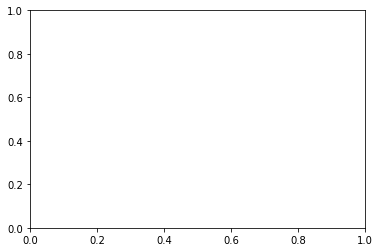

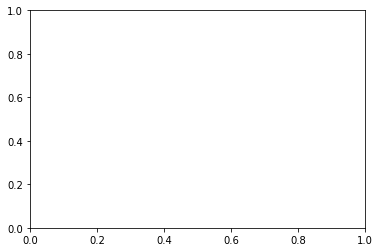

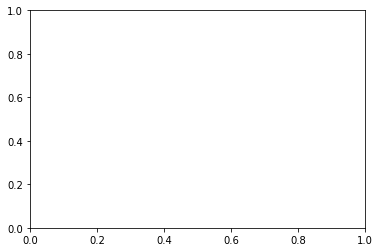

In [10]:
lp = lg.LaserProjection()
bag = rosbag.Bag(os.path.dirname(os.getcwd())+'/rosbags/2020-11-19-16-22-13.bag')

counter = 1

for topic, msg, t in bag.read_messages(topics=['/scan']):
    if counter in takers:
        if counter > 2535:
            break
        le = LineExtractionPaper(msg)
        pc2_msg = lp.projectLaser(msg)
        xyz_array = ros_numpy.point_cloud2.pointcloud2_to_xyz_array(pc2_msg)
        xy_laser = xyz_array[:,:2]

        
        create_picture(xy_laser)
        filename = f"img/explain/points{counter:04d}.png"
        plt.savefig(filename)
        corner_print(le.list_of_corners.corner_list, counter)
        create_picture(xy_laser)
        wall_print(le.list_of_walls.wall_list, counter)
        create_picture(xy_laser)
        door_print(le.list_of_doors.door_list, counter)
        create_picture(xy_laser)
        corridor_print(le.list_of_corridors.corridor_list, counter)
        plt.close()
        

    counter = counter+1